### Some useful points to keep in mind for transfer learning
Types of transfer learning
1. Features Extraction
2. Fine Tuning 

------------------------------------
1. **Feature Extraction** -> Can be done in two ways in TensorFlow
* Using **`tensorflow_hub`** -> We can choose any suitable architecture from (https://tfhub.dev/) and pass the url of features vector to tensorflow_hub. We can then use the object returned (`KerasLayer`)  inside Functional or Sequential API. Eg. https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5 -> This is feature vector of MobileNetV1_100_224 image classification model
* Using **`tf.keras.applications`** (https://www.tensorflow.org/api_docs/python/tf/keras/applications/) -> We can use prebuilt modules from applications api directly as layers of the model. The layer can be use inside Functional or Sequential API just like any other keras.layer

2. Fine Tuning -> In fine tuning instead of just training the last dense layer (we achieve this by setting `include_top = False` in application API) we train some of the layers from top. 
This is usually done in 2 steps:
* First we train the model for few epochs using feature vector transfer learning, and save the model weights using **`ModelCheckpoint`** callback if required. 
* Then we load the weights of the model using the saved CheckPoint and continue training from the current epoch. We achive this by setting **`initial_epoch`** parameter in `model.fit` method. The `initial_epoch` parameter is set to `history.history.epochs[-1]` to start training from the step till we have done feature vector transfer learning. 

For fine tuning, in the second step we usually keep the `learning_rate` as `1/10th` of the `learning_rate` of feature vector transfer learning. 

Also, for fine tuning, we first unfreeze the pretrained model (base_model) by `base_model.trainable = True`. Then we freeze the initial layers that we don't want to train

**Some commands related to Tensorboard**

`!tensorboard dev upload --logdir ./transfer_learning/ \`

`--name "Transfer Learning experiments with 10 Food101 classes" \`

`--description "Features extraction, data augmentation, fine tuning and data size experiments" \`

`--one_shot`

`!tensorboard dev list`

`!tensorboard dev delete --expriment_id <>`

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd


In [ ]:
!nvidia-smi

Wed Aug 10 08:10:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-10 08:10:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-10 08:10:33 (87.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

### Get some data
This time instead of getting model architecture from tensorflow hub, we'll use `tf.keras.applications`.
Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications 

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-08-10 08:10:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.240, 172.217.0.48, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   303MB/s    in 0.5s    

2022-08-10 08:10:34 (303 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent

#### Data generators

In [ ]:
train_dir = '10_food_classes_10_percent/train'
valid_dir = '10_food_classes_10_percent/test'

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

In [ ]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=valid_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical',
                                                                           batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
class_names = train_data_10_percent.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for images, labels in train_data_10_percent.take(1):
  print(images.shape, labels.shape)

(32, 224, 224, 3) (32, 10)


### Model 0 -> EfficientNetB0 using Functional API and `tf.keras.applications`
Building a transfer learning model using Keras Functional API (`using tf.keras.applications`)

In [ ]:
# 1. Create the base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    weights='imagenet', 
    include_top=False
)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create input layer
inputs = tf.keras.Input(shape=(IMG_SIZE)+(3,), name = "InputLayer")

# 4. Normalize (in case of not using EfficientNet)

# 5. Pass inputs to the base model
x = base_model(inputs)
print(f"Shape after passing input to the base model: {x.shape}.")
 
# 6. Average Pool
x = tf.keras.layers.GlobalAvgPool2D(name="GlobalAveragePooling")(x)
print(f"Shape after global average pooling 2D {x.shape}.")

# 7. Create output layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = "OutputLayer")(x)

# 8. Create the model using input and outputs
model_0 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_0.summary()

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing input to the base model: (None, 7, 7, 1280).
Shape after global average pooling 2D (None, 1280).
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling (Globa  (None, 1280)             0         
 lAveragePooling2D)                                              
                                                                 
 OutputLayer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,

In [ ]:
model_0.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

history_0 = model_0.fit(
    train_data_10_percent,
    epochs = EPOCHS,
    validation_data = test_data_10_percent,
    callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                            experiment_name = "10_percent_feature_extraction")
    ]
)

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220810-081042
Epoch 1/5
24/24 [==============================] - 26s 407ms/step - loss: 1.8898 - categorical_accuracy: 0.4133 - val_loss: 1.3296 - val_categorical_accuracy: 0.7044
Epoch 2/5
24/24 [==============================] - 8s 310ms/step - loss: 1.1515 - categorical_accuracy: 0.7267 - val_loss: 0.9230 - val_categorical_accuracy: 0.7976
Epoch 3/5
24/24 [==============================] - 8s 309ms/step - loss: 0.8425 - categorical_accuracy: 0.8107 - val_loss: 0.7565 - val_categorical_accuracy: 0.8240
Epoch 4/5
24/24 [==============================] - 8s 309ms/step - loss: 0.6952 - categorical_accuracy: 0.8413 - val_loss: 0.6660 - val_categorical_accuracy: 0.8392
Epoch 5/5
24/24 [==============================] - 8s 310ms/step - loss: 0.5857 - categorical_accuracy: 0.8640 - val_loss: 0.6122 - val_categorical_accuracy: 0.8428


In [ ]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 70ms/step - loss: 0.6122 - categorical_accuracy: 0.8428


[0.6121535897254944, 0.8428000211715698]

#### Just checking how many layers does the base model (efficientnet v2 has)

In [ ]:
for num, layer in enumerate(base_model.layers):
  print(num, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['categorical_accuracy']
  val_accuracy = history.history['val_categorical_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

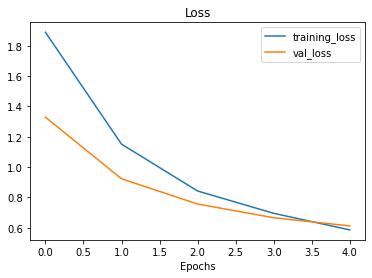

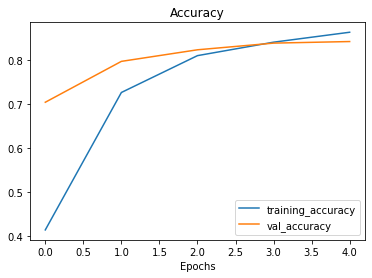

In [ ]:
plot_loss_curves(history_0)

### Getting a features vector from a trained model
Lets see what `GlobalAvgPooling2D` layer does and outputs.

(None, 7, 7, 1280) -> (None, 1280)

Example on (None, 4, 4, 3) -> ??

Compresses the inner 2 dimensions and takes average

In [ ]:
input_shape = (1,4,4,3)
tf.random.set_seed(42)

input = tf.random.normal(input_shape)
print(input.shape)

output = tf.keras.layers.GlobalAveragePooling2D()(input)
print(output.shape)

print(input)
print(output)

(1, 4, 4, 3)
(1, 3)
tf.Tensor(
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]], shape=(1, 4, 4, 3), dtype=float32)
tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)


**The vector output given by the `GlovalAvgPooling2D` layer is known as feature vector and it is passed to the output layer**

### Model 1 -> 1% data, data augmentation

1. `Model 1` > Feature extraction transfer learning with 1% of the data with data augmentation
2. `Model 2` > Feature extraction transfer learning with 10% of the data with data augmentation
3. `Model 3` > Fine-tuning transfer learning with 10% of the data with data augmentation
4. `Model 4` > Fine-tuning transfer learning with 100% of the data with data augmentation

> All experiments have same test data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2022-08-10 08:12:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.217.9.208, 142.251.45.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   214MB/s    in 0.6s    

2022-08-10 08:12:13 (214 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
unzip_data("10_food_classes_1_percent.zip")

In [ ]:
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [ ]:
walk_through_dir(train_dir_1_percent)
walk_through_dir(test_dir)

There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
T

In [ ]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = 'categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Data Augmentation in keras layers

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomHeight(0.2),
        tf.keras.layers.RandomWidth(0.2)
    ], name = "DataAugmentation"
)

10_food_classes_10_percent/train/sushi/1049178.jpg


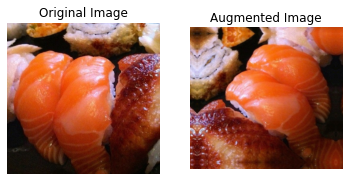

In [ ]:
# Visualize data augmentation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

target_class = random.choice(class_names)
target_path = train_dir
random_image = target_path + '/' + target_class + '/' + random.choice(os.listdir(target_path + '/' + target_class))
print(random_image)

img = mpimg.imread(random_image)

aug_img = data_augmentation(tf.expand_dims(img, 0), training=True)
aug_img = tf.squeeze(aug_img)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis(False)
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(aug_img/255.)
plt.axis(False)
plt.title("Augmented Image")
plt.show();


In [ ]:
input_shape = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(include_top = False,
                                                  weights = 'imagenet',
                                                  input_shape = input_shape)
base_model.trainable = False

inputs = tf.keras.Input(shape = input_shape, name = "InputLayer")
x = data_augmentation(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D(name="GlobalAvgPooling2D")(x)
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name="OutputLayer")(x)

model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_1.summary()

model_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

history_1 = model_1.fit(
    train_data_1_percent,
    epochs = EPOCHS,
    validation_data = test_data,
    steps_per_epoch = len(train_data_1_percent),
    validation_steps = 0.25 * len(test_data), ## will evaluate on 25% of the validation data
    callbacks = [create_tensorboard_callback("transfer_learning",
                                             "1_percent_data_aug")]
)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 DataAugmentation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 GlobalAvgPooling2D (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 OutputLayer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 7s 74ms/step - loss: 1.8330 - categorical_accuracy: 0.4720


[1.833003282546997, 0.47200000286102295]

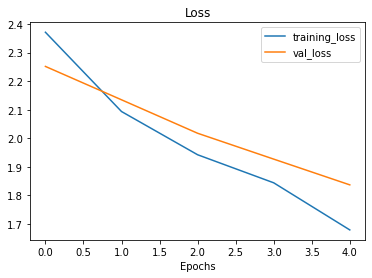

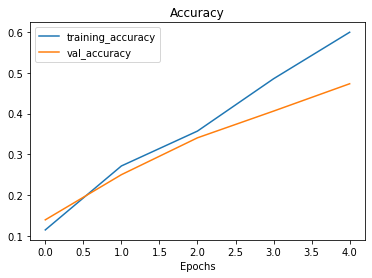

In [ ]:
plot_loss_curves(history_1)

### Model 2 -> 10% data, data augmentation

#### Introducing `ModelCheckpoint` Callback
Is saves the model while training at specified frequencies 
link: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint 

In [ ]:
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                         save_weights_only = True,
                                                         save_best_only = True,
                                                         save_freq = 'epoch',
                                                         verbose = 1
                                                         )

In [ ]:
input_shape = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(include_top = False,
                                                  input_shape = input_shape,
                                                  weights = 'imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape = input_shape, name = "InputLayer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name = "GlobalAveragePooling2D")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "OutputLayer")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

history_2 = model_2.fit(
    train_data_10_percent,
    epochs = EPOCHS,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data,
    validation_steps = 0.25 * len(test_data),
    callbacks = [create_tensorboard_callback("transfer_learning",
                                             "10_percent_data_aug"),
                 checkpoint_callback]
)

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220810-094013
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0227 - categorical_accuracy: 0.3400
Epoch 1: val_loss improved from inf to 1.46235, saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 347ms/step - loss: 2.0227 - categorical_accuracy: 0.3400 - val_loss: 1.4624 - val_categorical_accuracy: 0.6687
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3796 - categorical_accuracy: 0.6480
Epoch 2: val_loss improved from 1.46235 to 1.06328, saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 330ms/step - loss: 1.3796 - categorical_accuracy: 0.6480 - val_loss: 1.0633 - val_categorical_accuracy: 0.7578
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0691 - categorical_accuracy: 0.7293
Epoch 3: val_loss improved from 1.06328 to 0.8197

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.6920 - categorical_accuracy: 0.8064


[0.6919764876365662, 0.8064000010490417]

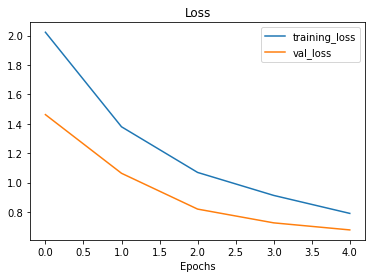

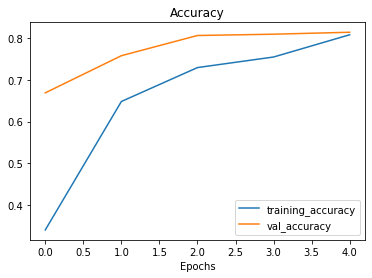

In [ ]:
plot_loss_curves(history_2)

In [ ]:
# Checking best model so far
results_0 = model_0.evaluate(test_data)
results_1 = model_1.evaluate(test_data)
results_2 = model_2.evaluate(test_data)

print(f"Model 0 loss: {results_0[0]}, accuracy: {results_0[1]}.")
print(f"Model 1 loss: {results_1[0]}, accuracy: {results_1[1]}.")
print(f"Model 2 loss: {results_2[0]}, accuracy: {results_2[1]}.")

79/79 [==============================] - 6s 70ms/step - loss: 0.6920 - categorical_accuracy: 0.8064
Model 0 loss: 0.6121537089347839, accuracy: 0.8428000211715698.
Model 1 loss: 1.8330035209655762, accuracy: 0.47200000286102295.
Model 2 loss: 0.6919764876365662, accuracy: 0.8064000010490417.


#### Loading in checkpointed weights
We had `save_best_only = True` while saving the model weights for model_2. And from the loss curves we can see that the state after the last epoch was best. So we can load in the saved model weights and see if the results are coming same.

In [ ]:
model_2.load_weights(checkpoint_path)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.6920 - categorical_accuracy: 0.8064


[0.6919764280319214, 0.8064000010490417]

**We can see that the results of model and loaded model are exact same**

## Model 3 -> 10% data, data augmentation, **unfreeze and fine tune top 10 layers**

🔑 **Fine tuning usually works best *after* we have run trained the model on custom data for some epochs using feature extraction, then we unfreeze some of the layers and train from the same checkpoint**

In [ ]:
model_2.layers

In [ ]:
# Layers in our model 2 and are they trainable
for layer in model_2.layers:
  print(f"{layer}\t{layer.trainable}")

<keras.engine.input_layer.InputLayer object at 0x7f713bca2a90>	True
<keras.engine.sequential.Sequential object at 0x7f72dde9ca50>	True
<keras.engine.functional.Functional object at 0x7f713d661d90>	False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f713bca2c90>	True
<keras.layers.core.dense.Dense object at 0x7f7140b7ae50>	True


In [ ]:
# Layers in Base model (EfficientNetB0) and are they trainable
for i, layer in enumerate(model_2.layers[2].layers):
  print(f"{i}\t{layer.name}\t{layer.trainable}")

0	input_19	False
1	rescaling_14	False
2	normalization_14	False
3	stem_conv_pad	False
4	stem_conv	False
5	stem_bn	False
6	stem_activation	False
7	block1a_dwconv	False
8	block1a_bn	False
9	block1a_activation	False
10	block1a_se_squeeze	False
11	block1a_se_reshape	False
12	block1a_se_reduce	False
13	block1a_se_expand	False
14	block1a_se_excite	False
15	block1a_project_conv	False
16	block1a_project_bn	False
17	block2a_expand_conv	False
18	block2a_expand_bn	False
19	block2a_expand_activation	False
20	block2a_dwconv_pad	False
21	block2a_dwconv	False
22	block2a_bn	False
23	block2a_activation	False
24	block2a_se_squeeze	False
25	block2a_se_reshape	False
26	block2a_se_reduce	False
27	block2a_se_expand	False
28	block2a_se_excite	False
29	block2a_project_conv	False
30	block2a_project_bn	False
31	block2b_expand_conv	False
32	block2b_expand_bn	False
33	block2b_expand_activation	False
34	block2b_dwconv	False
35	block2b_bn	False
36	block2b_activation	False
37	block2b_se_squeeze	False
38	block2b_se_re

In [ ]:
print(len(model_2.layers[2].trainable_variables))

0


#### Unfreeze last 10 layers

🔑 We fist need to make the base model trainable. This will unfreeze all the layers. Then we need to loop over the layers and freeze the initial layers, layers except last 10

In [ ]:
base_model.trainable = True
# To begin fine tuning let's unfreeze last 10 layers
for layer in base_model.layers[:-10]:
  print(f"Freezing layer: {layer.name}")
  layer.trainable = False

Freezing layer: input_19
Freezing layer: rescaling_14
Freezing layer: normalization_14
Freezing layer: stem_conv_pad
Freezing layer: stem_conv
Freezing layer: stem_bn
Freezing layer: stem_activation
Freezing layer: block1a_dwconv
Freezing layer: block1a_bn
Freezing layer: block1a_activation
Freezing layer: block1a_se_squeeze
Freezing layer: block1a_se_reshape
Freezing layer: block1a_se_reduce
Freezing layer: block1a_se_expand
Freezing layer: block1a_se_excite
Freezing layer: block1a_project_conv
Freezing layer: block1a_project_bn
Freezing layer: block2a_expand_conv
Freezing layer: block2a_expand_bn
Freezing layer: block2a_expand_activation
Freezing layer: block2a_dwconv_pad
Freezing layer: block2a_dwconv
Freezing layer: block2a_bn
Freezing layer: block2a_activation
Freezing layer: block2a_se_squeeze
Freezing layer: block2a_se_reshape
Freezing layer: block2a_se_reduce
Freezing layer: block2a_se_expand
Freezing layer: block2a_se_excite
Freezing layer: block2a_project_conv
Freezing layer:

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(f"{i}\t{layer.name}\t{layer.trainable}")

0	input_19	False
1	rescaling_14	False
2	normalization_14	False
3	stem_conv_pad	False
4	stem_conv	False
5	stem_bn	False
6	stem_activation	False
7	block1a_dwconv	False
8	block1a_bn	False
9	block1a_activation	False
10	block1a_se_squeeze	False
11	block1a_se_reshape	False
12	block1a_se_reduce	False
13	block1a_se_expand	False
14	block1a_se_excite	False
15	block1a_project_conv	False
16	block1a_project_bn	False
17	block2a_expand_conv	False
18	block2a_expand_bn	False
19	block2a_expand_activation	False
20	block2a_dwconv_pad	False
21	block2a_dwconv	False
22	block2a_bn	False
23	block2a_activation	False
24	block2a_se_squeeze	False
25	block2a_se_reshape	False
26	block2a_se_reduce	False
27	block2a_se_expand	False
28	block2a_se_excite	False
29	block2a_project_conv	False
30	block2a_project_bn	False
31	block2b_expand_conv	False
32	block2b_expand_bn	False
33	block2b_expand_activation	False
34	block2b_dwconv	False
35	block2b_bn	False
36	block2b_activation	False
37	block2b_se_squeeze	False
38	block2b_se_re

#### Compile the model_2 to incorporate layer unfreezing
🔑 **Note when using fine tuning, best practice is to lower learning rate (thump rule: by 10 percent)**

In [ ]:
model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
model_2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 DataAugmentation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 GlobalAveragePooling2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 OutputLayer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-trai

In [ ]:
len(model_2.trainable_variables)

12

#### Fine tune for another 5 epochs

In [ ]:
initial_epochs = EPOCHS

fine_tune_epochs = initial_epochs + EPOCHS

# Notice: the mode is still model_2, loaded from the checkpoint
history_3 = model_2.fit(
    train_data_10_percent,
    epochs = fine_tune_epochs,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data,
    validation_steps = 0.25 * len(test_data),
    callbacks = [create_tensorboard_callback("transfer_learning",
                                             "10_percent_fine_tune_last_10")],
    initial_epoch = history_2.epoch[-1] ## It will take the last epoch from the history of previous model run
)

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220810-104656
Epoch 5/10
24/24 [==============================] - 17s 400ms/step - loss: 0.6993 - categorical_accuracy: 0.8067 - val_loss: 0.5569 - val_categorical_accuracy: 0.8266
Epoch 6/10
24/24 [==============================] - 8s 300ms/step - loss: 0.5370 - categorical_accuracy: 0.8413 - val_loss: 0.4903 - val_categorical_accuracy: 0.8453
Epoch 7/10
24/24 [==============================] - 7s 291ms/step - loss: 0.4893 - categorical_accuracy: 0.8480 - val_loss: 0.4727 - val_categorical_accuracy: 0.8344
Epoch 8/10
24/24 [==============================] - 7s 264ms/step - loss: 0.4457 - categorical_accuracy: 0.8587 - val_loss: 0.4686 - val_categorical_accuracy: 0.8453
Epoch 9/10
24/24 [==============================] - 7s 285ms/step - loss: 0.3978 - categorical_accuracy: 0.8800 - val_loss: 0.4718 - val_categorical_accuracy: 0.8438
Epoch 10/10
24/24 [==============================] - 7s 299ms/step - loss

In [ ]:
# Model 3 is model_2 trained for 5 epochs + tranined again 
# for 5 epochs after unfreezing last 10 layers
results_3 = model_2.evaluate(test_data)

print(f"Model 0 loss: {results_0[0]}, accuracy: {results_0[1]}.")
print(f"Model 1 loss: {results_1[0]}, accuracy: {results_1[1]}.")
print(f"Model 2 loss: {results_2[0]}, accuracy: {results_2[1]}.")
print(f"Model 3 loss: {results_3[0]}, accuracy: {results_3[1]}.")

79/79 [==============================] - 7s 82ms/step - loss: 0.4952 - categorical_accuracy: 0.8328
Model 0 loss: 0.6121537089347839, accuracy: 0.8428000211715698.
Model 1 loss: 1.8330035209655762, accuracy: 0.47200000286102295.
Model 2 loss: 0.6919764876365662, accuracy: 0.8064000010490417.
Model 3 loss: 0.4952138662338257, accuracy: 0.8327999711036682.


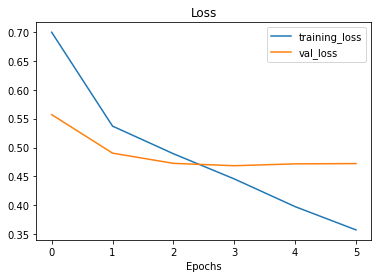

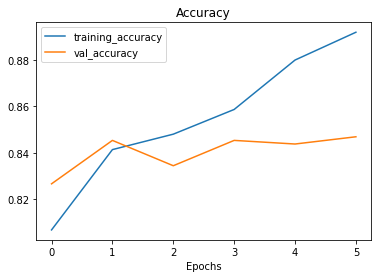

In [ ]:
plot_loss_curves(history_3)

#### Plot loss curves before and after fine-tuning

In [ ]:
def compare_histories(original_history, new_history, initial_epochs):
  loss = original_history.history['loss']
  val_loss = original_history.history['val_loss']

  accuracy = original_history.history['categorical_accuracy']
  val_accuracy = original_history.history['val_categorical_accuracy']

  total_loss = loss + new_history.history['loss']
  total_val_loss = val_loss + new_history.history['val_loss']

  total_accuracy = accuracy + new_history.history['categorical_accuracy']
  total_val_accuracy = val_accuracy + new_history.history['val_categorical_accuracy']

  plt.figure(figsize=(8, 8))

  plt.subplot(2, 1, 1)
  plt.plot(total_accuracy, label="Train accuracy")
  plt.plot(total_val_accuracy, label="Val accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Train loss")
  plt.plot(total_val_loss, label="Val loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")

  plt.show();

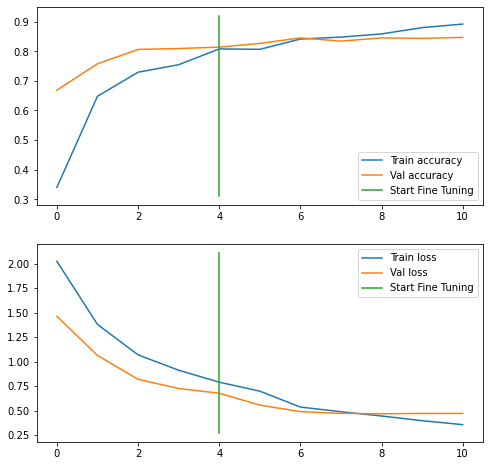

In [ ]:
compare_histories(history_2, history_3, initial_epochs=5)

## Model 4: 100% data, augmentation, fine tune -> Reload model_2 (feature extraction version)

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-08-10 11:19:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 142.251.45.16, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   143MB/s    in 3.5s    

2022-08-10 11:19:07 (143 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
unzip_data('10_food_classes_all_data.zip')

In [ ]:
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 

In [ ]:
#### Data Generators
train_dir = '10_food_classes_all_data/train/'
test_dir = '10_food_classes_all_data/test'

train_data_full = tf.keras.utils.image_dataset_from_directory(directory = train_dir,
                                                              image_size = IMG_SIZE,
                                                              label_mode = 'categorical',
                                                              batch_size = BATCH_SIZE)
test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
                                                        label_mode = 'categorical',
                                                        image_size = IMG_SIZE,
                                                        batch_size = BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
class_names = train_data_full.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomHeight(0.2),
        tf.keras.layers.RandomWidth(0.2)
    ], name = "DataAugmentation"
)

#### Reload model_2 again from the checkpoint

In [ ]:
model_2.load_weights(checkpoint_path)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.6920 - categorical_accuracy: 0.8064


[0.6919764876365662, 0.8064000010490417]

In [ ]:
## See the accuracy is again 80%, so we have loaded it properly

In [ ]:
model_2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 DataAugmentation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 GlobalAveragePooling2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 OutputLayer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-trai

In [ ]:
len(model_2.trainable_variables)

12

In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(f"{i}\t{layer.name}\t{layer.trainable}")

0	input_19	False
1	rescaling_14	False
2	normalization_14	False
3	stem_conv_pad	False
4	stem_conv	False
5	stem_bn	False
6	stem_activation	False
7	block1a_dwconv	False
8	block1a_bn	False
9	block1a_activation	False
10	block1a_se_squeeze	False
11	block1a_se_reshape	False
12	block1a_se_reduce	False
13	block1a_se_expand	False
14	block1a_se_excite	False
15	block1a_project_conv	False
16	block1a_project_bn	False
17	block2a_expand_conv	False
18	block2a_expand_bn	False
19	block2a_expand_activation	False
20	block2a_dwconv_pad	False
21	block2a_dwconv	False
22	block2a_bn	False
23	block2a_activation	False
24	block2a_se_squeeze	False
25	block2a_se_reshape	False
26	block2a_se_reduce	False
27	block2a_se_expand	False
28	block2a_se_excite	False
29	block2a_project_conv	False
30	block2a_project_bn	False
31	block2b_expand_conv	False
32	block2b_expand_bn	False
33	block2b_expand_activation	False
34	block2b_dwconv	False
35	block2b_bn	False
36	block2b_activation	False
37	block2b_se_squeeze	False
38	block2b_se_re

In [ ]:
model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(0.0001), ## Decrease learning rate
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

fine_tune_epochs = initial_epochs + EPOCHS

history_4 = model_2.fit(
    train_data_full, 
    epochs = fine_tune_epochs,
    steps_per_epoch = len(train_data_full),
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data)),
    callbacks = [create_tensorboard_callback("transfer_learning",
                                             "100_percent_fine_tune_last_10")],
    initial_epoch = history_2.epoch[-1]                       
)

Saving TensorBoard log files to: transfer_learning/100_percent_fine_tune_last_10/20220810-114219
Epoch 5/10
235/235 [==============================] - 54s 197ms/step - loss: 0.7349 - categorical_accuracy: 0.7665 - val_loss: 0.4343 - val_categorical_accuracy: 0.8635
Epoch 6/10
235/235 [==============================] - 44s 184ms/step - loss: 0.5955 - categorical_accuracy: 0.8092 - val_loss: 0.3453 - val_categorical_accuracy: 0.9112
Epoch 7/10
235/235 [==============================] - 39s 165ms/step - loss: 0.5255 - categorical_accuracy: 0.8343 - val_loss: 0.3109 - val_categorical_accuracy: 0.9161
Epoch 8/10
235/235 [==============================] - 41s 173ms/step - loss: 0.4750 - categorical_accuracy: 0.8476 - val_loss: 0.3335 - val_categorical_accuracy: 0.9062
Epoch 9/10
235/235 [==============================] - 44s 186ms/step - loss: 0.4351 - categorical_accuracy: 0.8631 - val_loss: 0.3247 - val_categorical_accuracy: 0.9079
Epoch 10/10
235/235 [==============================] - 36s

In [ ]:
results_4 = model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.3293 - categorical_accuracy: 0.8864


In [ ]:
print(f"Model 0 loss: {results_0[0]}, accuracy: {results_0[1]}.")
print(f"Model 1 loss: {results_1[0]}, accuracy: {results_1[1]}.")
print(f"Model 2 loss: {results_2[0]}, accuracy: {results_2[1]}.")
print(f"Model 3 loss: {results_3[0]}, accuracy: {results_3[1]}.")
print(f"Model 4 loss: {results_4[0]}, accuracy: {results_4[1]}.")

Model 0 loss: 0.6121537089347839, accuracy: 0.8428000211715698.
Model 1 loss: 1.8330035209655762, accuracy: 0.47200000286102295.
Model 2 loss: 0.6919764876365662, accuracy: 0.8064000010490417.
Model 3 loss: 0.4952138662338257, accuracy: 0.8327999711036682.
Model 4 loss: 0.3293220102787018, accuracy: 0.8863999843597412.


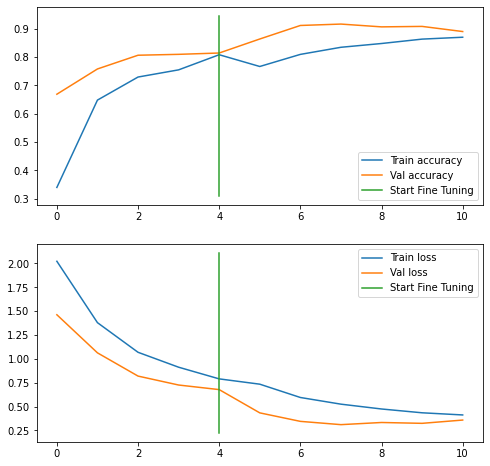

In [ ]:
compare_histories(history_2, history_4, initial_epochs = 5)

## Tensorboard visualization

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning/ \
  --name "Transfer Learning experiments with 10 Food101 classes" \
  --description "Features extraction, data augmentation, fine tuning and data size experiments" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/9ZsAGvAwSPKbXdE1W24peQ/

[2022-08-10T11:58:17] Started scanning logdir.
[2022-08-10T11:58:22] Total uploaded: 162 scalars, 0 tensors, 5 binary objects (4.1 MB)
[2022-08-10T11:58:22] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/9ZsAGvAwSPKbXdE1W24peQ/


In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/9ZsAGvAwSPKbXdE1W24peQ/
	Name                 Transfer Learning experiments with 10 Food101 classes
	Description          Features extraction, data augmentation, fine tuning and data size experiments
	Id                   9ZsAGvAwSPKbXdE1W24peQ
	Created              2022-08-10 11:58:17 (26 seconds ago)
	Updated              2022-08-10 11:58:22 (21 seconds ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4300050
https://tensorboard.dev/experiment/KSzsaRJSQnObr5GYdBRqRQ/
	Name                 EfficientNetB0 v/s Resnet50v2
	Description          Comparing two different features extractors from Tensoflow Hub 
	Id                   KSzsaRJSQnObr5GYdBRqRQ
	Created              2022-08-10 04:03:35 (7 hours ago)
	Updated              2022-08-10 04:03:38 (7 hours ago)
	Runs                 6
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes 